In [0]:
te! pip install minisom rx

In [0]:
from operator import methodcaller
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from minisom import MiniSom
from rx import Observable
from matplotlib.gridspec import GridSpec

In [0]:
# dataset overview

DATA_PATH = './cardio_train.csv' 
df = pd.read_csv(DATA_PATH, sep=';')
print(df.shape)
df.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data description

- age: in days
- gender:
 - 1: women
 - 2: men
- height: in cm
- weight: in kg
- ap_hi: Systolic blood pressure
- ap_lo: Diastolic blood pressure
- cholesterol:
 - 1: normal
 - 2: above normal
 - 3: well above normal
- gluc:
 - 1: normal
 - 2: above normal
 - 3: well above normal
- smoke: binary feature
- alco: binary feature
- active: binary feature
- cardio: target feature


In [0]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [0]:
df.drop(['id'], axis=1, inplace=True)

In [0]:
sum(df.isnull().sum(), df.isna().sum())

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [0]:
df = df.dropna()

In [0]:
Y = df['cardio'].astype('int8')
df.drop('cardio', axis=1, inplace=True)

In [0]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000


## Rescaling

In [0]:
df = df.apply(lambda col: col / col.max())

In [0]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,0.821021,0.674786,0.657437,0.371028,0.008041,0.008785,0.455624,0.408819,0.088129,0.053771,0.803729
std,0.104046,0.238419,0.032841,0.071979,0.009614,0.017134,0.226750,0.190757,0.283484,0.225568,0.397179
min,0.455362,0.500000,0.220000,0.050000,-0.009363,-0.006364,0.333333,0.333333,0.000000,0.000000,0.000000
25%,0.744908,0.500000,0.636000,0.325000,0.007491,0.007273,0.333333,0.333333,0.000000,0.000000,1.000000
50%,0.830894,0.500000,0.660000,0.360000,0.007491,0.007273,0.333333,0.333333,0.000000,0.000000,1.000000
75%,0.899380,1.000000,0.680000,0.410000,0.008739,0.008182,0.666667,0.333333,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# K-Means

In [0]:
kmeans = KMeans(n_clusters=2, random_state=42)

y_pred = kmeans.fit_predict(df[['ap_hi', 'ap_lo']])

df['y_pred'] = y_pred

In [0]:
sick = df[df['y_pred'] == 1]
no_sick = df[df['y_pred'] == 0]

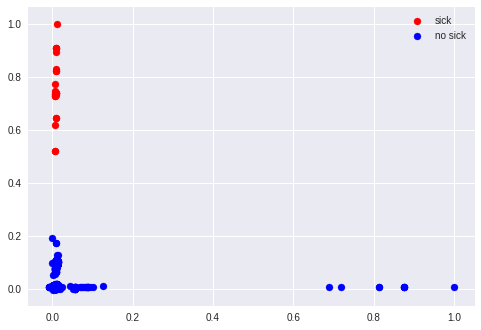

In [0]:
plt.scatter(sick['ap_hi'], sick['ap_lo'], label='sick', c='r', cmap=plt.cm.viridis)
plt.scatter(no_sick['ap_hi'], no_sick['ap_lo'], label='no sick', c='b', cmap=plt.cm.viridis)
plt.legend()

In [0]:
metrics.fowlkes_mallows_score(Y, y_pred)

0.7068594794590015

In [0]:
y_pred = kmeans.fit_predict(df[['gluc', 'ap_lo', 'ap_hi']])

df['y_pred'] = y_pred

In [0]:
metrics.fowlkes_mallows_score(Y, y_pred)

0.6118979831014529

In [0]:
sick = df[df['y_pred'] == 1]
no_sick = df[df['y_pred'] == 0]

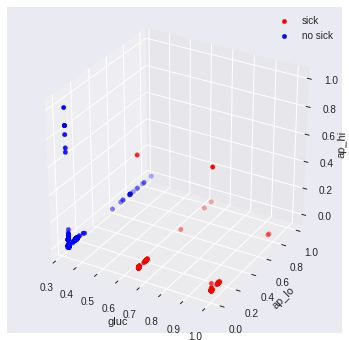

In [0]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sick['gluc'], sick['ap_lo'], sick['ap_hi'], label='sick', c='r', cmap=plt.cm.viridis)
ax.scatter(no_sick['gluc'], no_sick['ap_lo'], no_sick['ap_hi'], label='no sick', c='b', cmap=plt.cm.viridis)
ax.set_xlabel('gluc')
ax.set_ylabel('ap_lo')
ax.set_zlabel('ap_hi')
plt.legend()

In [0]:
y_pred = kmeans.fit_predict(df[['cholesterol', 'ap_lo', 'ap_hi', 'gluc']])

In [0]:
metrics.fowlkes_mallows_score(Y, y_pred)

0.6031253957295085

# Hierarchical Clustering

In [0]:
X = df[['ap_hi', 'ap_lo']][::2]

hiec_clust = AgglomerativeClustering(n_clusters=2, linkage='single')
y_pred = hiec_clust.fit_predict(X.values)

X['y_pred'] = y_pred

metrics.fowlkes_mallows_score(Y[::2], y_pred)

0.7070566833496869

In [0]:
sick = X[X['y_pred'] == 1]
no_sick = X[X['y_pred'] == 0]

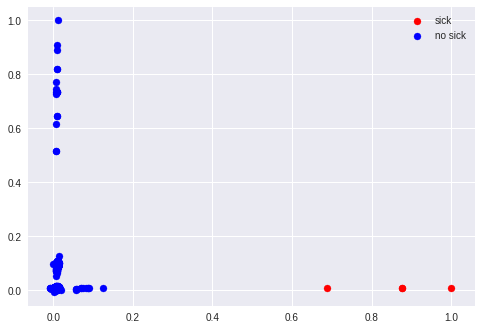

In [0]:
plt.scatter(sick['ap_hi'], sick['ap_lo'], label='sick', c='r', cmap=plt.cm.viridis)
plt.scatter(no_sick['ap_hi'], no_sick['ap_lo'], label='no sick', c='b', cmap=plt.cm.viridis)
plt.legend()

In [0]:
X = df[['gluc', 'ap_lo', 'ap_hi']][::2]

hiec_clust = AgglomerativeClustering(n_clusters=2, linkage='single')
y_pred = hiec_clust.fit_predict(X.values)

X['y_pred'] = y_pred

metrics.fowlkes_mallows_score(Y[::2], y_pred)

0.7070566833496869

In [0]:
sick = X[X['y_pred'] == 1]
no_sick = X[X['y_pred'] == 0]

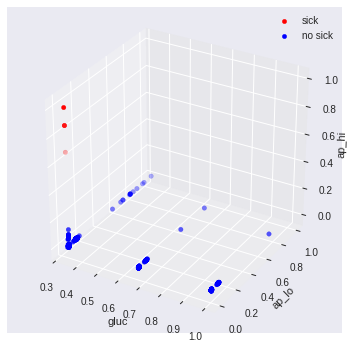

In [0]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sick['gluc'], sick['ap_lo'], sick['ap_hi'], label='sick', c='r', cmap=plt.cm.viridis)
ax.scatter(no_sick['gluc'], no_sick['ap_lo'], no_sick['ap_hi'], label='no sick', c='b', cmap=plt.cm.viridis)
ax.set_xlabel('gluc')
ax.set_ylabel('ap_lo')
ax.set_zlabel('ap_hi')
plt.legend()

In [0]:
X = df[['ap_hi', 'ap_lo', 'gluc', 'cholesterol']][::2]

hiec_clust = AgglomerativeClustering(n_clusters=2, linkage='single')
y_pred = hiec_clust.fit_predict(X)

metrics.fowlkes_mallows_score(Y[::2], y_pred)

0.7070566833496869

In [0]:
hiec_clust = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='single')
y_pred = hiec_clust.fit_predict(X)

metrics.fowlkes_mallows_score(Y[::2], y_pred)

0.7070566833496869

In [0]:
hiec_clust = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
y_pred = hiec_clust.fit_predict(X)

metrics.fowlkes_mallows_score(Y[::2], y_pred)

0.7070566833496869

# SOM(Self Organized Map)

In [0]:
data = df[['ap_hi', 'ap_lo', 'gluc', 'cholesterol']].values

In [0]:
map_dim = 15
som = MiniSom(map_dim, map_dim, 4, sigma=0.3, learning_rate=0.4)
som.train_random(data, int(1e3))

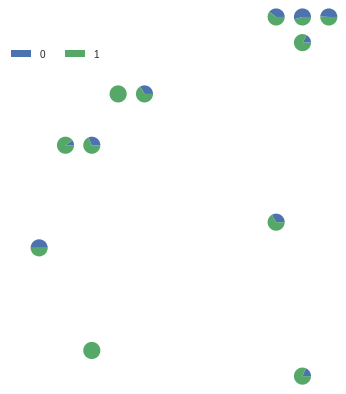

In [0]:
labels_map = som.labels_map(data, Y)
label_names = np.unique(Y)

plt.figure(figsize=(7, 7))
the_grid = GridSpec(map_dim, map_dim)

for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names, bbox_to_anchor=(0, 3), ncol=3)
plt.show()

In [0]:
qt = som.quantization_error(data)

In [0]:
qt

0.4354005821890988

In [0]:
weigths = som.distance_map()

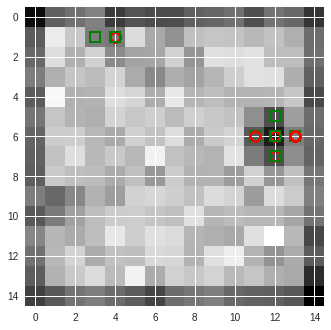

In [0]:
def _(x, ind):
  markers = ['o', 's']
  colors = ['r', 'g']
 
  win = som.winner(x)
  plt.plot(win[0], win[1],
           markers[Y[ind]],
           markeredgecolor = colors[Y[ind]],
           markersize=10,
           markerfacecolor='None',
           markeredgewidth=2)

data_test = data[: 1000]
plt.imshow(som.distance_map().T, cmap=plt.cm.gray)
[*map(_, data_test, range(len(data_test)))]
plt.show()